# Snap Buildings

## Explore shapely.snap

In [3]:
from shapely.geometry import box, Polygon
import geopandas as gpd
import geoplanar
import shapely

In [11]:
from shapely.geometry import Polygon

p1 = Polygon( [[0, 0], [1,0], [1,1], [0,1] ] )
p2 = Polygon( [(1.1, 0), (2.1,0), (2.1,1), (1.1,1) ] )

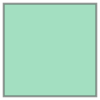

In [12]:
p1

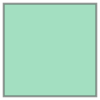

In [13]:
p2

In [15]:
gdf = gpd.GeoDataFrame(geometry=[p1,p2])

<Axes: >

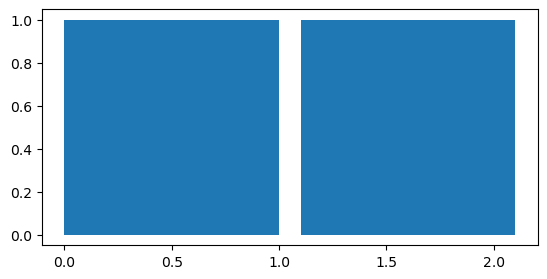

In [16]:
gdf.plot()

In [17]:
list(p1.exterior.coords)

[(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.0, 1.0), (0.0, 0.0)]

### tolerance 0

In [18]:
p3=shapely.snap(p1,p2,0)

In [19]:
gdf3 = gpd.GeoDataFrame(geometry=[p3,p2])

<Axes: >

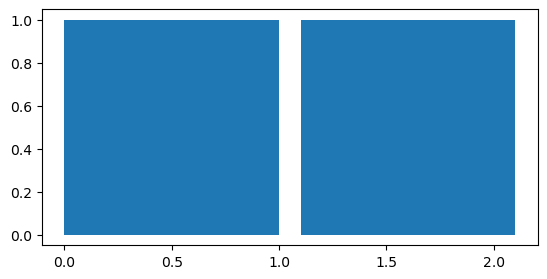

In [20]:
gdf3.plot()

### tolerance 1

In [21]:
p3=shapely.snap(p1,p2,1)

<Axes: >

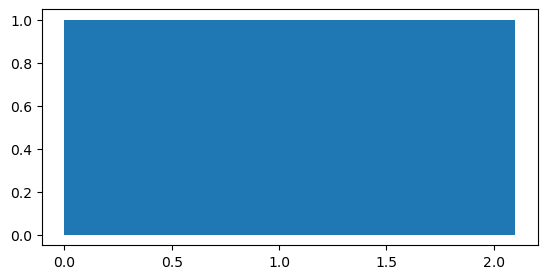

In [22]:
gpd.GeoDataFrame(geometry=[p3,p2]).plot()

## Only vertices get snapped together, not edges

In [24]:
p4 = Polygon( [[0, 0], [1,0], [1,1], [0,1] ] )
p5 = Polygon( [(1.1, 0), (2.1,0), (2.1,2), (1.1,2) ] )

In [25]:
p6=shapely.snap(p4,p5,1)

<Axes: >

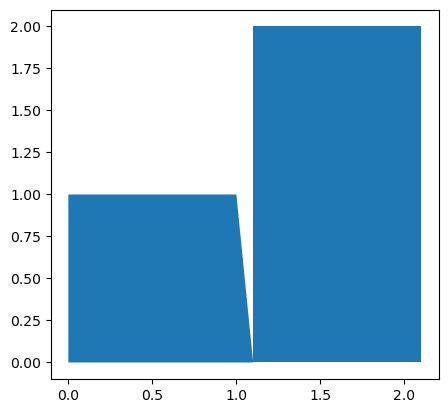

In [26]:
gpd.GeoDataFrame(geometry=[p6,p5]).plot()

## Explore solution from https://gis.stackexchange.com/questions/203058/why-is-shapelys-snapping-geo-snaps-not-working-as-expected

In [99]:
list(nearest_points(p4, p5))

[<POINT (1 0)>, <POINT (1.1 0)>]

In [101]:
from shapely.ops import nearest_points

def snap(g1, g2, threshold):
    coordinates = []
    for x, y in g1.exterior.coords:  # for each vertex in the first line
        point = shapely.Point(x, y)
        p1, p2 = nearest_points(point, g2)  # find the nearest point on the second line
        print(p1, p2)
        if p1.distance(p2) <= threshold:
            # it's within the snapping tolerance, use the snapped vertex
            coordinates.append(p2.coords[0])
        else:
            # it's too far, use the original vertex
            coordinates.append((x, y))
    # convert coordinates back to a LineString and return
    return coordinates

In [102]:
p6=snap(p4,p5,1)

POINT (0 0) POINT (1.1 0)
POINT (1 0) POINT (1.1 0)
POINT (1 1) POINT (1.1 1)
POINT (0 1) POINT (1.1 1)
POINT (0 0) POINT (1.1 0)


In [96]:
p6

[(0.0, 0.0), (1.1, 0.0), (1.1, 1.0), (0.0, 1.0), (0.0, 0.0)]

<Axes: >

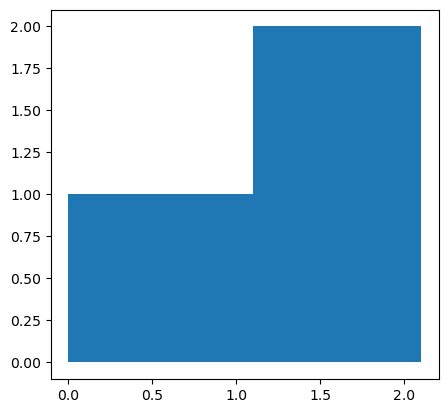

In [98]:
gpd.GeoDataFrame(geometry=[Polygon(p6),p5]).plot()

## Testing irregular shapes

In [123]:
p7 = Polygon( [[0, 0], [1,0], [1.3,1.3], [0.3,1] ] )
p8 = Polygon( [(1.07, 0.2), (2.3,1), (1.5,2)] )

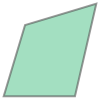

In [124]:
p7

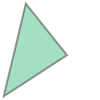

In [125]:
p8

<Axes: >

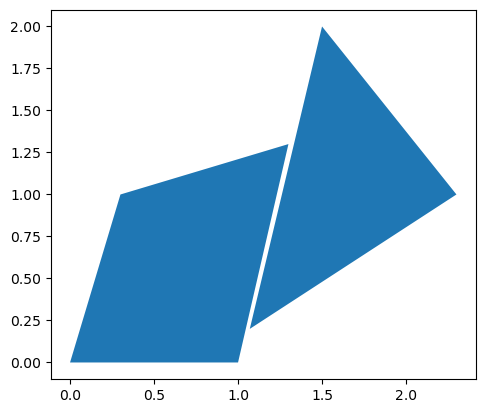

In [126]:
gpd.GeoDataFrame(geometry=[p7,p8]).plot()

In [130]:
p9=snap(p7,p8,0.1)

POINT (0 0) POINT (1.07 0.2)
POINT (1 0) POINT (1.07 0.2)
POINT (1.3 1.3) POINT (1.331008204619113 1.2925924844521006)
POINT (0.3 1) POINT (1.2092236269672108 0.7827965780022774)
POINT (0 0) POINT (1.07 0.2)


In [131]:
p9

[(0.0, 0.0),
 (1.0, 0.0),
 (1.331008204619113, 1.2925924844521006),
 (0.3, 1.0),
 (0.0, 0.0)]

<Axes: >

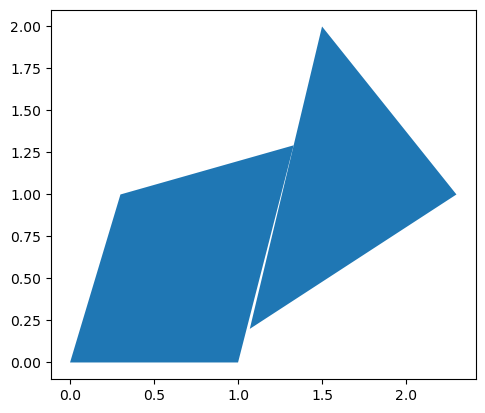

In [132]:
gpd.GeoDataFrame(geometry=[Polygon(p9),p8]).plot()

Issue: The bottom right vertex of the quadrilateral does not get snapped to left line of the triangle

Idea 1: repeat for other shape and this should cover all edges (twice the computation)

Idea 2: shapely segmentize and snap. create more vertices along line and find nearest point for each vertex (more compuation depending on how many extra vertices)

## Idea 1

In [134]:
p10=snap(p8,p7,0.1)

POINT (1.07 0.2) POINT (1.0473595505617979 0.2052247191011236)
POINT (2.3 1) POINT (1.2848314606741573 1.234269662921348)
POINT (1.5 2) POINT (1.3 1.3)
POINT (1.07 0.2) POINT (1.0473595505617979 0.2052247191011236)


<Axes: >

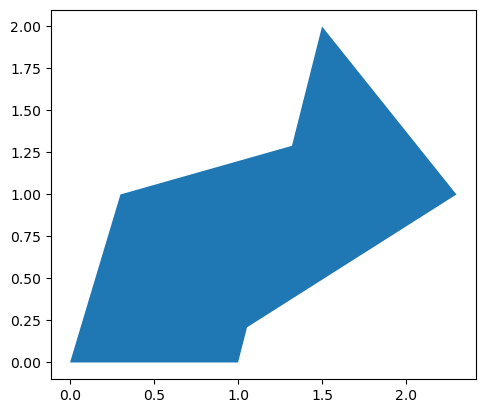

In [135]:
gpd.GeoDataFrame(geometry=[Polygon(p9),Polygon(p10)]).plot()

# Final code

In [136]:
from shapely.ops import nearest_points

def snap(g1, g2, threshold):
    
    g1coordinates = []
    g2coordinates = []

    for x, y in g1.exterior.coords:  # for each vertex in the first polygon
        point = shapely.Point(x, y)
        p1, p2 = nearest_points(point, g2)  # find the nearest point in the second polygon
        if p1.distance(p2) <= threshold:
            # if it's within the snapping tolerance, use the snapped vertex
            g1coordinates.append(p2.coords[0])
        else:
            # it's too far, use the original vertex
            g1coordinates.append((x, y))

    for x, y in g2.exterior.coords:  # for each vertex in the second polygon
        point = shapely.Point(x, y)
        p1, p2 = nearest_points(point, g1)  # find the nearest point in the second polygon
        if p1.distance(p2) <= threshold:
            # if it's within the snapping tolerance, use the snapped vertex
            g2coordinates.append(p2.coords[0])
        else:
            # it's too far, use the original vertex
            g2coordinates.append((x, y))
    
    return g1coordinates, g2coordinates

or use sjoin_nearest, perhaps quicker? https://gis.stackexchange.com/questions/426161/snap-points-to-polygon-lines-in-python-shapely

In [152]:
p11,p12=snap(p7,p8,0.1)

<Axes: >

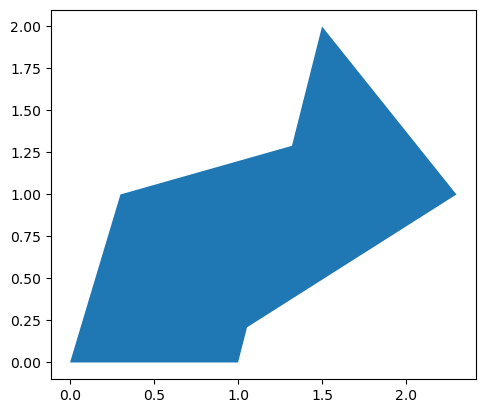

In [153]:
gpd.GeoDataFrame(geometry=[Polygon(p11),Polygon(p12)]).plot()

In [162]:
p13,p14=snap(p4,p5,0.11)

<Axes: >

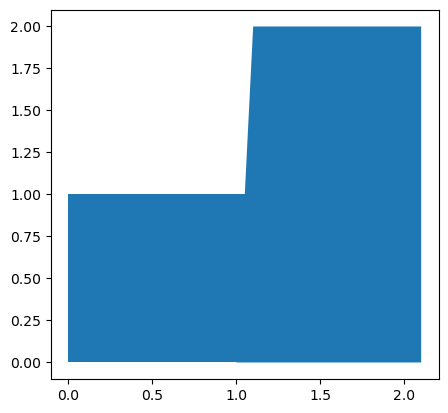

In [163]:
gpd.GeoDataFrame(geometry=[Polygon(p13),Polygon(p14)]).plot()

Idea 2: shapely segmentize and snap. create more vertices along line and find nearest point for each vertex (more compuation depending on how many extra vertices)